# Monet Art Challenge

## Overview

### Generative Adversarial Networks

Generative Adversarial Networks (GANs) are a class of artificial intelligence algorithms used for generating new data instances.  GANs consist of two neural networks: a generator and a discriminator, which are trained simultaneously through a game-like scenario. The generator tries to produce data samples that are indistinguishable from real data, while the discriminator aims to differentiate between real and fake data.

During training, the generator generates fake samples and the discriminator evaluates them. The discriminator is trained to improve its ability to distinguish between real and fake samples.
Simultaneously, the generator is trained to generate samples that the discriminator classifies as real. This process is repeated iteratively, with both networks improving their performance over time.

The objective is to minimize the difference between the distribution of generated data and real data. The discriminator aims to maximize the probability of assigning the correct labels to real and fake samples, while the generator aims to minimize this probability.

Here, we'll be using GANs to generate fake images.

### Problem Overview

The challenge is to build a GAN that generates 7,000-10,000 images in the style of Claude Monet.

The provided data includes:
- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

The output must be calles 'images.zip' and contain 7000-1000 images sized 256x256.

Submissions are evaluated on Memorization-informed Frechet Inception Distance (MiFID). The smaller the MiFID, the more believable the generated images are.

### Data Overview

We are provideed with 4 directories:
- photo_tfrec
- photo_jpg
- monet_tfrec
- money_jpg

The images are provided in JPEG and TFREC formats. The directory ```'monet_jpg'``` contains 300 images of paintings made by Claude Monet. The directory ```'photo_jpg'``` contain 7038 photo images. All images are 256x256 pixels in RGB format. The Monet images are to be used to train the network to learn Monet's style. The photo images are to be used to train the network. The photo images are also to be altered to fit Monet's style. These generated images are to be compressed into a file called ```images.zip``` for submission.


### Inspect the Data

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import shutil
import os
import pandas as pd

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.16.1


#### JPEG Files

First, we will preprocess the JPEG images by resizing them to a fixed size and normalizing their pixel values.

Here, we will read in the JPEG image and return a tensor containing the raw image data. Then, we decode the tensor using ```channels = 3 ``` indicating the image has 3 color channels (RGB). Finally, we preprocess the JPEG as described above and return the preprocessed image tensor.

In [8]:
# Function to preprocess and augment image data
def preprocess_image(image):
    # Resize images to a fixed size
    image = tf.image.resize(image, [256, 256])
    # Normalize pixel values to the range [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

# Function to load images from JPEG files
def load_jpeg_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess_image(image)
    return image

In [9]:
# Define the directory for the JPEG images
monet_jpgs = '/Users/alyso/Downloads/gan-getting-started/monet_jpg/'
photo_jpgs = '/Users/alyso/Downloads/gan-getting-started/photo_jpg/'

In [10]:
# Load and preprocess JPEG datasets
monet_jpg_dataset = tf.data.Dataset.list_files(os.path.join(monet_jpgs, "*.jpg"))
photos_jpg_dataset = tf.data.Dataset.list_files(os.path.join(photo_jpgs, "*.jpg"))

monet_jpg_dataset = monet_jpg_dataset.map(load_jpeg_image, num_parallel_calls=AUTOTUNE)
photos_jpg_dataset = photos_jpg_dataset.map(load_jpeg_image, num_parallel_calls=AUTOTUNE)

In [11]:
print('No. of Monet JPEG files: ',len(monet_jpg_dataset))
print('No. of Photo JPEG files: ',len(photos_jpg_dataset))

No. of Monet JPEG files:  300
No. of Photo JPEG files:  7028


We can see that we have 300 Monet images and 7038 photos.

#### TFRecord Files - model

In [13]:
monet_files= tf.io.gfile.glob('/Users/alyso/Downloads/gan-getting-started/monet_tfrec/*.tfrec')
photo_files= tf.io.gfile.glob('/Users/alyso/Downloads/gan-getting-started/photo_tfrec/*.tfrec')

In [14]:
image_size = [256,256]

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels = 3)
    image = (tf.cast(image, tf.float32)/127.5) - 1 
    image = tf.reshape(image, [*image_size, 3])
    return image

def parse_tfrecord(example):
    """
    Parses a single TFRecord example containing image data.
    
    Args:
        example (tf.Tensor): A single example from a TFRecord file.
        
    Returns:
        tf.Tensor: Decoded image tensor.
    """
    # Define the expected features in the TFRecord file
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    return preprocess_image(example['image'])

In [15]:
def load_dataset(filenames, labeled=True, ordered=False):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(parse_tfrecord, num_parallel_calls = AUTOTUNE)
    return data

In [16]:
monet_ds = load_dataset(monet_files, labeled = True).batch(1).prefetch(buffer_size = AUTOTUNE)
photo_ds = load_dataset(photo_files, labeled = True).batch(1).prefetch(buffer_size = AUTOTUNE)
photo_og_ds = load_dataset(photo_files, labeled = True).batch(1).prefetch(buffer_size = AUTOTUNE)

### TFRecord Files - visualizing

In [23]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def parse_tfrecord(example):
    """
    Parses a single TFRecord example containing image data.
    
    Args:
        example (tf.Tensor): A single example from a TFRecord file.
        
    Returns:
        tf.Tensor: Decoded image tensor.
    """
    # Define the expected features in the TFRecord file
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    
    # Parse the example based on the feature description
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode a JPEG image with 3 channels
    image = tf.image.decode_image(example['image'], channels=3)
    
    return image



In [24]:
# Load TFRecord files
monet_dataset = tf.data.TFRecordDataset(monet_files)
photo_dataset = tf.data.TFRecordDataset(photo_files)
# Parse TFRecord files
photos_tfrec_dataset = photo_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000)
monet_tfrec_dataset = monet_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000)

### Visualize the Data

In [25]:
# Visualize sample images
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i, image in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i+1)
        plt.imshow((image.numpy()))
        plt.axis('off')
    plt.show()
    for image in dataset.take(1):  # Display shapes of the image
        print("Image shape:", image.shape)

Sample Monet TFRecord Images:


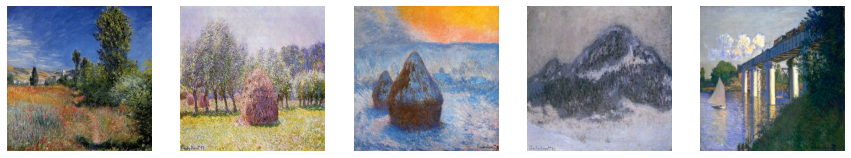

Image shape: (256, 256, 3)
Sample Photo TFRecord Images:


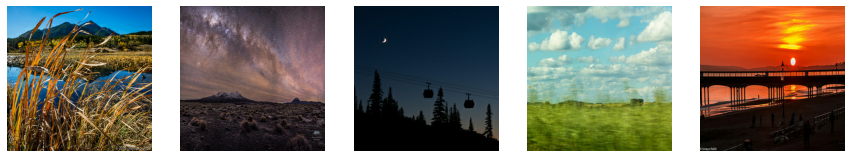

Image shape: (256, 256, 3)


In [26]:
print("Sample Monet TFRecord Images:")
visualize_samples(monet_tfrec_dataset)

print("Sample Photo TFRecord Images:")
visualize_samples(photos_tfrec_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample Monet JPEG Images:


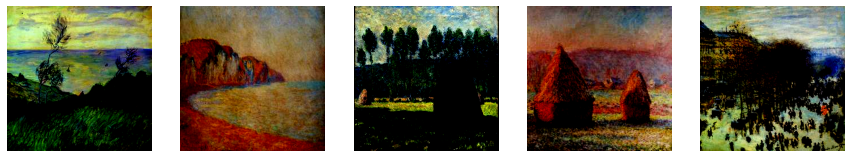

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (256, 256, 3)
Sample Photo JPEG Images:


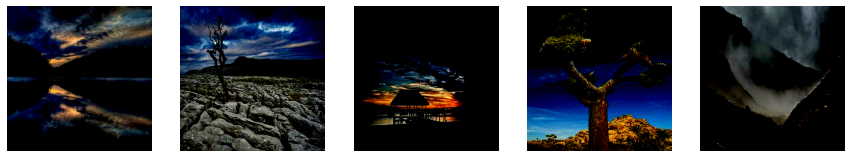

Image shape: (256, 256, 3)


In [28]:
print("Sample Monet JPEG Images:")
visualize_samples(monet_jpg_dataset)

print("Sample Photo JPEG Images:")
visualize_samples(photos_jpg_dataset)

The JPEG images appear to be darker than the TFRecord files. This could be because of preprocessing. 

Let's take a look at the distribution of intensity across colors for the images.

In [29]:
def plot_aggregate_color_histograms(directory): 
    """
    Calculate and plot aggregate color histograms for all images in the given directory.

    Paramets: 
    - directory: The path to the directory containing the images
    """
    color_data = {'r': [], 'g': [], 'b': []}

    # Loop over the files in the directory to read and calculate histograms
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'): 
            file_path = os.path.join(directory, filename)
            img = Image.open(file_path)
            img_array = np.array(img)
            for i, color in enumerate(['r', 'g', 'b']): 
                hist, _ = np.histogram(img_array[:, :, i], bins = 256, range = (0, 256))
                color_data[color].append(hist)

    # Calculate the mean histogram for each color
    mean_histograms = {color: np.mean(np.stack(hists), axis = 0) for color, hists in color_data.items()}

    # Plot the mean histograms
    plt.figure(figsize = (14, 4))
    plt.title(f'Mean Color Histograms for {os.path.basename(directory)}')
    for color, hist in mean_histograms.items(): 
        plt.plot(hist, color = color)

    plt.xlim([0, 256])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

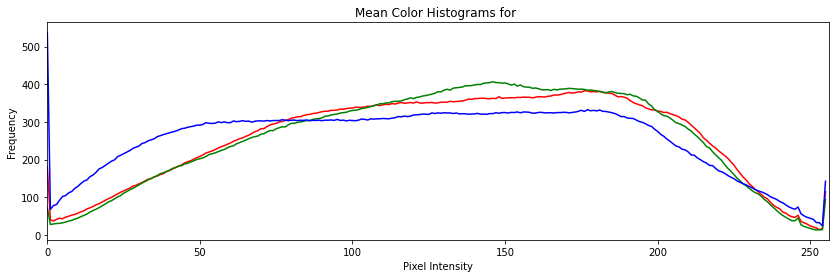

In [32]:
plot_aggregate_color_histograms(monet_jpgs)

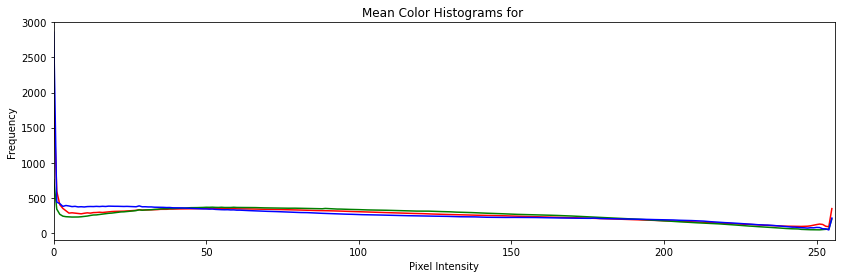

In [33]:
plot_aggregate_color_histograms(photo_jpgs)

Despite the overall dark appearance of the JPEG data, the histograms show quite a difference in the distributions here. This is interesting. It's not particularly surprising, Claude Monet is a a renowned Impressionist painter known for his paintings of the French countryside. It's not surprising he employs a wide range of tones and colors in his works. 

### Clean the Data

We have already done some data cleaning in the inspection step. When bringing in the images, we resized them to make them uniform and normalized the pixel values. 

Some additional common image data cleaning includes:
- checking for corrupted images
- removing duplicate images
- data augmentation

In [34]:
# Data augmentation
if ROTATE_AND_ZOOM:
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(factor=0.2, fill_mode='reflect'),
        layers.RandomZoom(height_factor=0.2, fill_mode='reflect')
    ])
    
else:
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
    ])

def apply_augmentation(image):
    image = data_augmentation(image, training=True)
    return image

In [35]:
monet_ds = monet_ds.map(apply_augmentation, num_parallel_calls = AUTOTUNE)
photo_ds = photo_ds.map(apply_augmentation, num_parallel_calls = AUTOTUNE)

## Model Architecture

In our model architecture, we will make use of upsampling and downsampling.

**Upsampling**: also known as 'deconvolution' or 'transpose convolution', upsampling increases the spatial resolution of data. This is typically done in the generator network to transform low-resolution input into a higher resolution output that resembles target data. These layers learn to fill in details and produce higher resultion images by applying filters to expand the spatial dimensions.
<br>

**Downsampling**: as the name would suggest, downsampling reduces the spatial dimensions of the data. It is typically done in the discriminator network to gradually reduce the resolution of the input data. This helps the discriminator focus more on more abstract features of the data/ It is often achieved through max pooling or strided convolutions

In [36]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [37]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Generator - Full Layers

In [38]:
def Generator_F():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Generator - Reduced Layers

In [40]:
def Generator_R():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
    ]

    up_stack = [
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator

In [41]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

#### Create Models

In [42]:
with strategy.scope():
    monet_generator = Generator_R() # transforms photos to Monet-esque paintings
    photo_generator = Generator_R() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [43]:

print("\033[1mMonet Generator Model Summary:\033[0m")
monet_generator.summary()

Monet Generator Model Summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 128,  │      3,072 │ input_layer_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 64, 64,    │    131,328 │ sequential_1[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 32, 32,    │    524,800 │ sequential_2[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 16, 16,    │  2,098,176 │ sequential_3[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 32, 32,    │  2,097,664 │ sequential_4[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 64, 64,    │  1,048,832 │ concatenate[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 128, 128,  │    262,272 │ concatenate_1[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 128)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 256, 256,  │      6,147 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,172,291 (23.55 MB)

 Trainable params: 6,172,291 (23.55 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:

print("\033[1mPhoto Generator Model Summary:\033[0m")
photo_generator.summary()

Photo Generator Model Summary:


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 128,  │      3,072 │ input_layer_9[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64, 64,    │    131,328 │ sequential_8[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 32, 32,    │    524,800 │ sequential_9[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  2,098,176 │ sequential_10[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 32, 32,    │  2,097,664 │ sequential_11[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ sequential_12[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64, 64,    │  1,048,832 │ concatenate_3[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ sequential_13[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 128, 128,  │    262,272 │ concatenate_4[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ sequential_14[0]… │
│ (Concatenate)       │ 128)              │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 256, 256,  │      6,147 │ concatenate_5[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,172,291 (23.55 MB)

 Trainable params: 6,172,291 (23.55 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:

print("\033[1mMonet Discriminator Model Summary:\033[0m")
monet_discriminator.summary()

Monet Discriminator Model Summary:


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_14          │ (None, 31, 31, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:

print("\033[1mPhoto Discriminator Model Summary:\033[0m")
monet_discriminator.summary()

Photo Discriminator Model Summary:


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_14          │ (None, 31, 31, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    def build(self, input_shape):
        self.m_gen.build(input_shape)
        self.p_gen.build(input_shape)
        self.m_disc.build(input_shape)
        self.p_disc.build(input_shape)
        #super(CycleGan, self).build(input_shape)
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [48]:
with strategy.scope():
    def discriminator_loss(real, generated):
        if LOSS_TYPE == 'bce':
            real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

            generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        
        elif LOSS_TYPE == 'mse':
            real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real), real)

            generated_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5


with strategy.scope():
    def generator_loss(generated):
        if LOSS_TYPE == 'bce':
            return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        elif LOSS_TYPE == 'mse':
            return tf.keras.losses.MeanSquaredError()(tf.ones_like(generated), generated)
   
    

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1


with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [49]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator,
        photo_generator, 
        monet_discriminator, 
        photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [51]:
print("\033[1mCycleGAN Model Summary:\033[0m")
cycle_gan_model.summary()

CycleGAN Model Summary:


Model: "cycle_gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_9 (Functional)       │ ?                      │     6,172,291 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_18 (Functional)      │ ?                      │     6,172,291 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_23 (Functional)      │ ?                      │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_28 (Functional)      │ ?                      │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,875,720 (68.19 MB)

 Trainable params: 17,875,720 (68.19 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [52]:
# Model Tuning Parameters
MODEL_NAME = 'model_1'
LOSS_TYPE = 'bce'
ROTATE_AND_ZOOM = False
EPOCHS = 10

In [53]:
# Set up checkpoint callback
checkpoint_path = 'checkpoints/'
checkpoint_name = 'cp-{epoch:04d}.weights.h5'
filepath = checkpoint_path + checkpoint_name
checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    verbose=0,
    save_weights_only=True,
    save_freq=3000) # Save CKPT every 10 epochs (1 epoch = 300 batches)

In [54]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS,
    callbacks = [checkpoint_callback]
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - monet_disc_loss: 0.6622 - monet_gen_loss: 5.1077 - photo_disc_loss: 0.6348 - photo_gen_loss: 5.3008 - loss: 0.0000e+00
Epoch 2/10


c:\Users\alyso\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - monet_disc_loss: 0.6612 - monet_gen_loss: 3.6290 - photo_disc_loss: 0.6400 - photo_gen_loss: 3.7100 - loss: 0.0000e+00
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - monet_disc_loss: 0.6558 - monet_gen_loss: 3.5438 - photo_disc_loss: 0.6299 - photo_gen_loss: 3.6451 - loss: 0.0000e+00
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - monet_disc_loss: 0.6519 - monet_gen_loss: 3.3755 - photo_disc_loss: 0.6247 - photo_gen_loss: 3.4777 - loss: 0.0000e+00
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - monet_disc_loss: 0.6358 - monet_gen_loss: 3.2379 - photo_disc_loss: 0.6129 - photo_gen_loss: 3.3311 - loss: 0.0000e+00
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - monet_disc_loss: 0.6334 - monet_gen_loss: 3.1468 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.2389 - loss: 0.0000e+00
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - monet_disc_loss: 0.6265 - monet_gen_loss: 3.0876 - photo_disc_loss: 0.6074 - photo_gen

In [55]:
if not os.path.exists('/kaggle/working/checkpoints'):
    os.makedirs('/kaggle/working/checkpoints')

In [56]:
cycle_gan_model.save_weights(f'/kaggle/working/checkpoints/{MODEL_NAME}_gan.weights.h5')

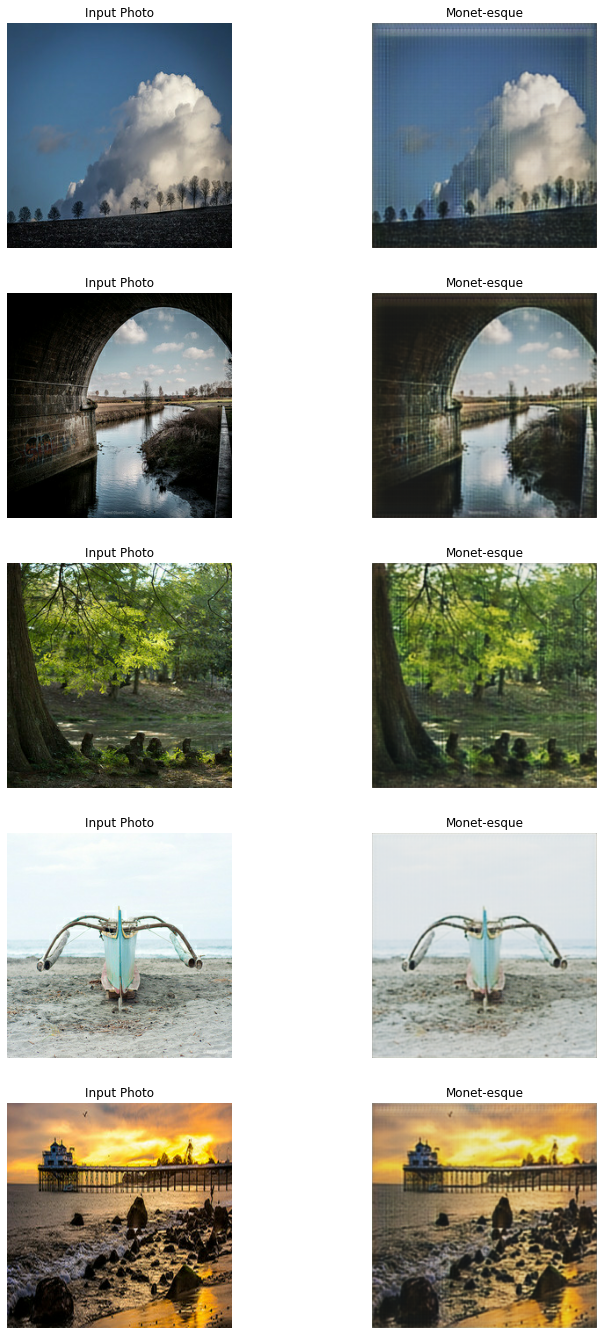

In [57]:
_, ax = plt.subplots(5, 2, figsize=(12, 24))
for i, img in enumerate(photo_og_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS,
    callbacks = [checkpoint_callback]
)

In [58]:
if not os.path.exists('../images'):
    os.makedirs('../images')

In [60]:
i = 1
for img in photo_og_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(f"../images/" + str(i) + ".jpg")
    i += 1

In [61]:
source_folder = "../images"
destination_folder = ".."

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Zip the 'images' folder into the 'downloads' folder
shutil.make_archive(os.path.join(destination_folder, "images"), 'zip', source_folder)

'c:\\Users\\alyso\\images.zip'

## Results and Analysis

In this project, we evaluated the generated images qualitatively and quantitatively. We observed that the images began to exhibit a style reminiscent of Monet's paintings, with the network learning to add brushwork-like texture. Overall, it wasn't very convincing and it only did an OK job. I created a separate notebook with only the model (- EDA and - Visualization sections) where I could easily change the loss, data augmentation, and epoch parameters. I also tried 

Part of this performance may be due to the photo dataset. In his paintings, Monet focused on the French countryside. In the image data set, there are all types of things present you wouldn't typically find in a Monet painting or in the country during his life. The modern aspects of the photo dataset may have cause the CycleGAN to prioritize generalizing well across lighting conditions and subjects. It is possible that if the photo dataset were constrained to lighting and subject conditions more similar to Monet's style, it may generalize more poorly but translate the photos to Monet's distinctive style better. 

Tuning parameters such as network architectures and loss functions had some impact on the model performance. The models using the generator with reduced layers did not perform as well as with the full layers, though it was faster. Using BCE loss provided a better score than using MSE loss. Interestingly, augmenting the data with flips and rotations cause a lower score. Maybe this is again pushing the network to generalize well across conditions, where what we actually want in this case is for the model to do a fairly specific task well. In general, augmentation works well to help prevent overfitting but here it may have caused some unnecessary confusion for the model.

Tuning hyperparameters such as epoch number and learning rate had some impact on the model performance. The models with higher epoch numbers performed better than those with lower epochs. The learning rates of 0.0002 and 0.0001 did not make a major change in the model performance. 

In [67]:
# Create DataFrame of the results
results = pd.DataFrame.from_records([
    ('model_1', 'reduced layers', 'bce', True, 10, 71.25931),
    ('model_2', 'reduced layers', 'mse', True, 10, 79.14133),
    ('model_3', 'reduced layers', 'bce', False, 10, 72.35366),
    ('model_4',  'reduced layers','mse', False, 10, 78.58562),
    ('model_5', 'full layers', 'bce', True, 10, 60.82402),
    ('model_6', 'full layers', 'bce', False, 10, 67.13222),
    ('model_7', 'reduced layers', 'bce', False, 50, 58.05645),
    ('model_8', 'full layers', 'bce', False, 50, 55.74453),
], columns=['model', 'layers', 'loss', 'rotate_&_zoom', 'epoch', 'score'])

display(results.sort_values('score'))

,model,layers,loss,rotate_&_zoom,epoch,score
7,model_8,full layers,bce,False,50,55.74453
6,model_7,reduced layers,bce,False,50,58.05645
4,model_5,full layers,bce,True,10,60.82402
5,model_6,full layers,bce,False,10,67.13222
0,model_1,reduced layers,bce,True,10,71.25931
2,model_3,reduced layers,bce,False,10,72.35366
3,model_4,reduced layers,mse,False,10,78.58562
1,model_2,reduced layers,mse,True,10,79.14133


## Conclusion

Overall, the best performing model had the full layers, no data augmentation, BCE loss, and 50 epochs. It did however take a long time to run, so tuning or parallelization might be able to improve this. Tuning improved on the performance slightly, but was not able to generate convincing Monet-style paintings.  

Additional exploration of network architectures, loss function, and learning rates could be used to further improve on this. Increasing the training data also would be helpful, since this data set had very few Monet paintings vs photos. Additionally, using images that more closely align to Monet's typical subject matter may help with training and performance. 
Incorporating domain-specific constraints to refine the generated images and exploring other artistic domains would be interesting future work. 